Install `xlrd` for reading the `xls` file

In [1]:
# %conda install xlrd==2.0.1

Set the path to the `xls` file

In [2]:
training_file = "../TrainDataset2024.xls"
# training_file = "/kaggle/input/dataset/TrainDataset2024.xls"

Import libraries

In [3]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath('../'))  # Adjust the path as needed

from my_util import df_to_corr_matrix

import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from matplotlib.colors import Normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif

from imblearn.over_sampling import SMOTE

from joblib import Parallel, delayed

from pickle import dump , load

import warnings

2024-11-30 23:35:11.234878: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-30 23:35:11.248511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733009711.261579   80749 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733009711.265100   80749 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 23:35:11.281129: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Cleaning the data

In [4]:
data = pd.read_excel(training_file)
data.drop(["ID", "RelapseFreeSurvival (outcome)"], axis=1, inplace=True)
data_no_na = data.replace(999, np.nan)
data_no_na.dropna(ignore_index=True, inplace=True)
X = data_no_na.drop('pCR (outcome)', axis=1)
y = data_no_na['pCR (outcome)']

print("Read the data into X and y. Dropped all rows with missing value.")

Read the data into X and y. Dropped all rows with missing value.


Drop features with high correlation

(308, 118)
Saved highly_correlated_features to: pkl/highly_correlated_features.pkl
(53, 53)


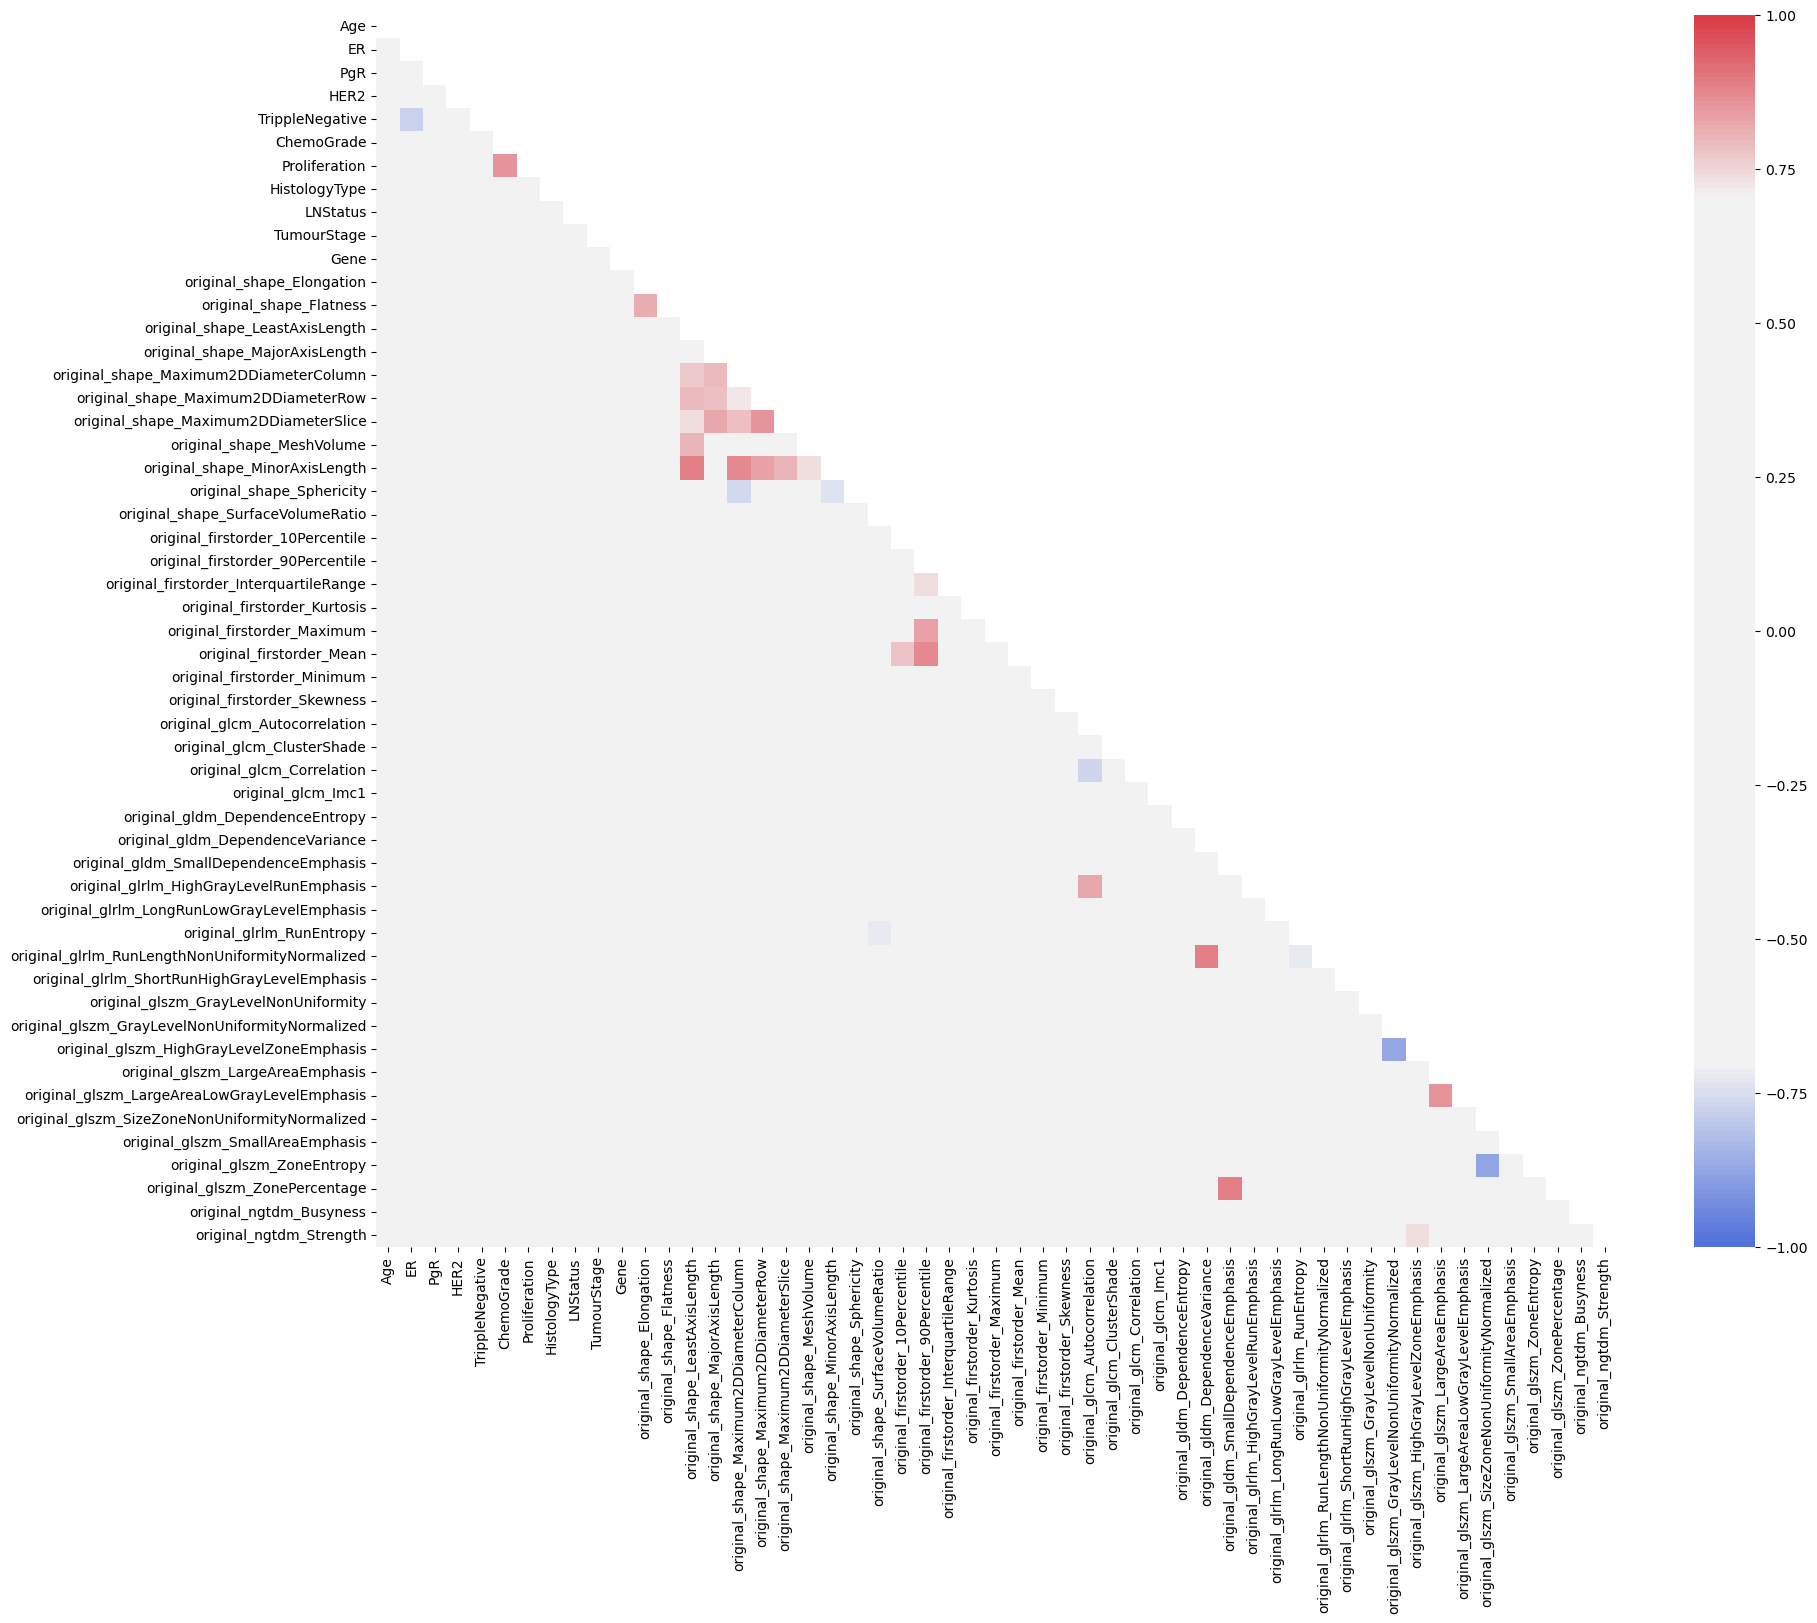

In [ ]:
print(X.shape)

CORR_THRESHOLD = 0.9
# Create a correlation matrix
correlation_matrix = X.corr()

highly_correlated_features = set()

for i in range(len(correlation_matrix.columns)):
  for j in range(i):
    if abs(correlation_matrix.iloc[i, j]) > CORR_THRESHOLD:
        highly_correlated_features.add(correlation_matrix.columns[i])

with open("pkl/highly_correlated_features.pkl", 'wb') as file:
   dump(highly_correlated_features, file)
   print(f"Saved highly_correlated_features to: {file.name}")

X_no_highly_correlated = X.drop(columns=highly_correlated_features)

df_to_corr_matrix(X_no_highly_correlated, sep=180, annot=False, size_factor=2)

Plot the heatmap for all data

In [6]:
# # Create a correlation matrix
# correlation_matrix = data.corr()
# mask = np.zeros_like(correlation_matrix)
# mask[np.triu_indices_from(mask)] = True

# # Create a heatmap with a custom colormap and normalization
# plt.clf()
# plt.figure(figsize=(70, 50))
# cmap = sns.diverging_palette(260, 10, sep=200, as_cmap=True)
# sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap=cmap, mask=mask, square=False)
# plt.title('Correlation Heatmap')
# plt.show()

Split the data into train_full and test (untouched)

In [26]:
while True:  
    X_train_full, X_test_reserved, y_train_full, y_test_reserved = train_test_split(X_no_highly_correlated, y, test_size=0.2, random_state=11) # similar distribution of 1 and 0
    # X_train_full, X_test_reserved, y_train_full, y_test_reserved = train_test_split(X_no_highly_correlated, y, test_size=0.2, random_state=None)

    X_train_full.reset_index(drop=True, inplace=True)
    X_test_reserved.reset_index(drop=True, inplace=True)
    y_train_full.reset_index(drop=True, inplace=True)
    y_test_reserved.reset_index(drop=True, inplace=True)

    ratio_train = sum(y_train_full[y_train_full==1]) / len(y_train_full)
    ratio_test = sum(y_test_reserved[y_test_reserved==1]) / len(y_test_reserved)

    if abs(ratio_train - ratio_test) < 0.1:
        break

print("Splited the data into train and test. The test will not be used in the training, but just for test the model. ")
print(f"The training data has {len(X_train_full)} data. The testing data has {len(X_test_reserved)} data. ")
print(f"Positive ratio: \n\tTrain: {ratio_train:.5f}\n\tTest: {ratio_test:.5f}")


Splited the data into train and test. The test will not be used in the training, but just for test the model. 
The training data has 246 data. The testing data has 62 data. 
Positive ratio: 
	Train: 0.17073
	Test: 0.17742


### Normalisation

#### Standardisation

In [27]:
scaler = StandardScaler()
Xs_standardisation = scaler.fit_transform(X_train_full)
Xs_standardisation = pd.DataFrame(Xs_standardisation, columns=X_train_full.columns)

with open("pkl/StandardScaler.pkl", "wb") as file:
    dump(scaler, file)
    print("Saved scaler to 'pkl/StandardScaler.pkl'")

Saved scaler to 'pkl/StandardScaler.pkl'


### Robust Scaler

In [28]:
scaler = RobustScaler()
Xs_robustScaler = scaler.fit_transform(X_train_full)
Xs_robustScaler = pd.DataFrame(Xs_robustScaler, columns=X_train_full.columns)

with open("pkl/RobustScaler.pkl", "wb") as file:
    dump(scaler, file)
    print("Saved scaler to 'pkl/RobustScaler.pkl'")

Saved scaler to 'pkl/RobustScaler.pkl'


### Feature Selection

In [29]:
SCALER = "standard"

In [30]:
# SCALER = "robust"

In [31]:
if SCALER == "standard":
    Xs = Xs_standardisation
else:
    Xs = Xs_robustScaler

In [32]:
# # Replaced by the following parallel process code generated by AI

# TARGET_NUM_OF_FEATURES = 10

# features = {}
# for K in range(1, TARGET_NUM_OF_FEATURES + 5):
#     best = {}
#     for i in range(K+5):
#         k_best = SelectKBest(score_func=mutual_info_classif, k=K)
#         Xs_k_best = k_best.fit_transform(Xs, y_train_full)
#         for feature in (k_best.get_feature_names_out()):
#             if feature in best:
#                 best[feature] += 1
#             else:
#                 best[feature] = 1
#     sorted_best = dict(sorted(best.items(), key=lambda item: item[1], reverse=True))
#     for key in best:
#         if best[key] > (K-2):
#             if key in features:
#                 features[key] += 1
#             else:
#                 features[key] = 1

# sorted_best

In [33]:
TARGET_NUM_OF_FEATURES = 15

features = {}

def process_k_best(K, i):
    k_best = SelectKBest(score_func=mutual_info_classif, k=K)
    Xs_k_best = k_best.fit_transform(Xs, y_train_full)
    return k_best.get_feature_names_out()

# Run in parallel
for K in range(1, TARGET_NUM_OF_FEATURES + 5):
    best = {}
    results = Parallel(n_jobs=-1)(delayed(process_k_best)(K, i) for i in range(K + 5))
    
    for feature_list in results:
        for feature in feature_list:
            if feature in best:
                best[feature] += 1
            else:
                best[feature] = 1

    sorted_best = dict(sorted(best.items(), key=lambda item: item[1], reverse=True))
    
    # Update features based on the counts
    for key in best:
        if best[key] > (K - 2):
            features[key] = features.get(key, 0) + 1

# Final sorted best features
sorted_best

{'Age': 24,
 'Gene': 24,
 'original_shape_Maximum2DDiameterSlice': 24,
 'original_shape_SurfaceVolumeRatio': 24,
 'original_firstorder_90Percentile': 24,
 'original_firstorder_InterquartileRange': 24,
 'original_firstorder_Minimum': 24,
 'original_glcm_Imc1': 24,
 'original_glrlm_RunLengthNonUniformityNormalized': 24,
 'original_ngtdm_Strength': 24,
 'original_glszm_SizeZoneNonUniformityNormalized': 23,
 'original_shape_MinorAxisLength': 20,
 'PgR': 20,
 'original_glcm_Correlation': 17,
 'original_glszm_GrayLevelNonUniformity': 17,
 'original_glszm_ZoneEntropy': 16,
 'HER2': 15,
 'ChemoGrade': 13,
 'Proliferation': 13,
 'ER': 11,
 'HistologyType': 9,
 'TrippleNegative': 9,
 'LNStatus': 9,
 'original_glszm_ZonePercentage': 8,
 'TumourStage': 5,
 'original_glszm_GrayLevelNonUniformityNormalized': 5,
 'original_glszm_HighGrayLevelZoneEmphasis': 4,
 'original_glrlm_ShortRunHighGrayLevelEmphasis': 2}

In [34]:
sorted_features = dict(sorted(features.items(), key=lambda item: item[1], reverse=True))
feature_names = list(sorted_features.keys())

num_max = sum(np.array(list(sorted_best.values())) == max(sorted_best.values()))

num_of_features = max(num_max, TARGET_NUM_OF_FEATURES)

important_features = ["Gene", "ER", "HER2"]

selected_features = list(set(important_features + feature_names[:num_of_features]))
num_of_features = len(selected_features)

print(f"Best {num_of_features} features are: ")
print(selected_features)

with open("pkl/selected_features.pkl", "wb") as file:
    dump(selected_features, file)

Best 16 features are: 
['original_firstorder_InterquartileRange', 'original_ngtdm_Strength', 'original_shape_SurfaceVolumeRatio', 'Age', 'original_shape_Maximum2DDiameterSlice', 'original_firstorder_90Percentile', 'PgR', 'original_glrlm_RunLengthNonUniformityNormalized', 'HER2', 'LNStatus', 'original_glcm_Imc1', 'original_firstorder_Minimum', 'Gene', 'original_glszm_SizeZoneNonUniformityNormalized', 'original_shape_MinorAxisLength', 'ER']


(16, 16)


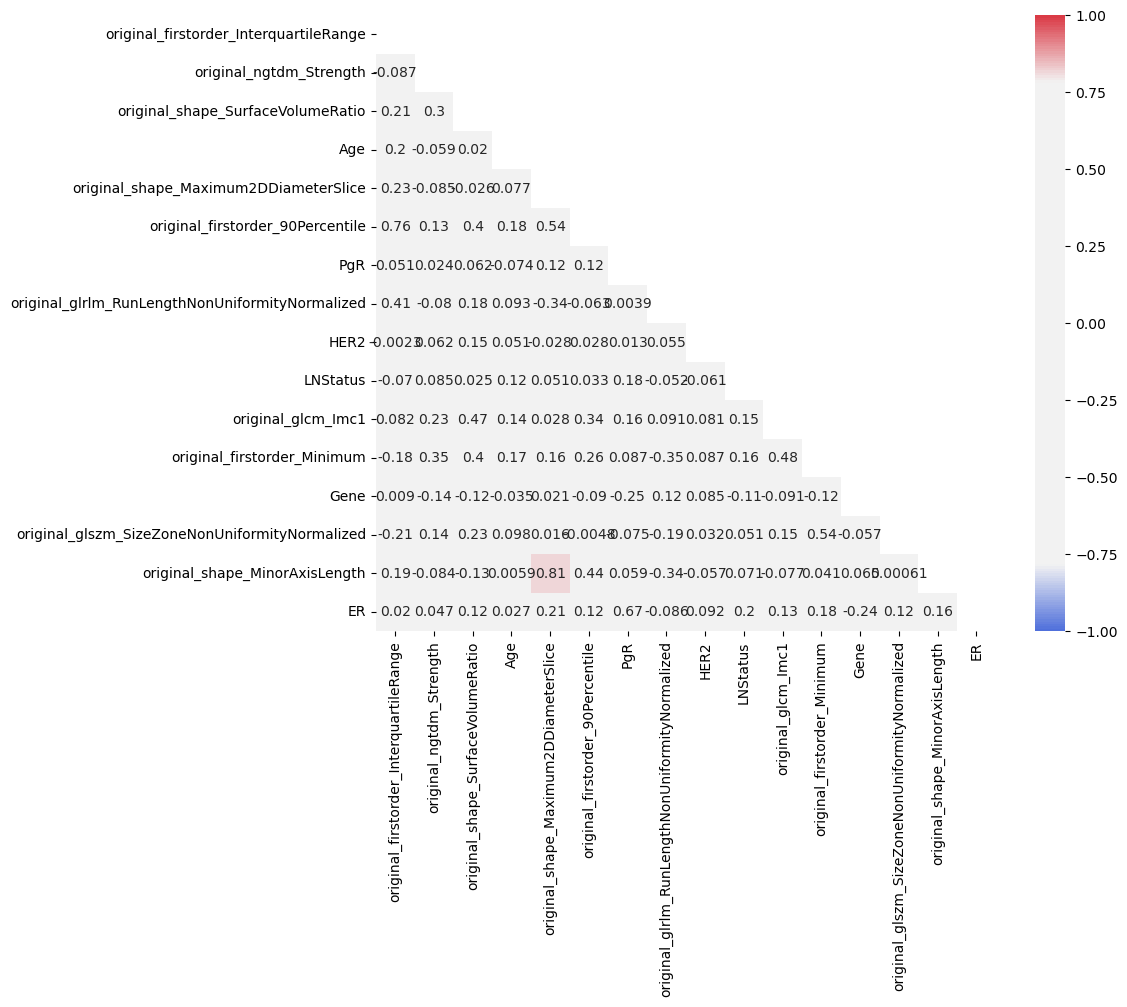

In [35]:
temp = X_train_full[selected_features]
df_to_corr_matrix(temp)

### PCA

In [124]:
NUM_OF_PCA_FEATURE = 8

Xs_selected = Xs[selected_features]

pca = PCA(n_components=10)
X_pca = pca.fit_transform(Xs_selected)

with open("pkl/pca.pkl", mode="wb") as file:
  dump(pca, file)
  print(f"Saved pca file to: {file.name}")

X_pca = X_pca[:, :NUM_OF_PCA_FEATURE]

Saved pca file to: pkl/pca.pkl


(8, 8)


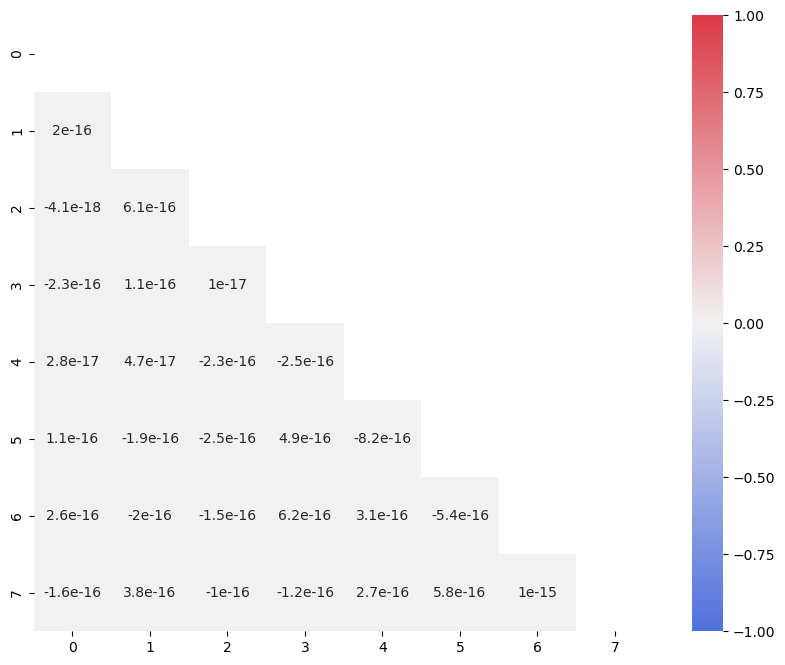

In [125]:
temp = pd.DataFrame(X_pca)
df_to_corr_matrix(temp, sep=1)

#### Resample

In [126]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y_train_full)

print(X_resampled.shape)
print(y_resampled.shape)

(408, 8)
(408,)


#### SVM

In [127]:
model = SVC()

# Define the parameter grid
param_grid = {
    'C': [0.07, 0.1, 0.2, 0.3],
    'gamma': ['scale', 'auto'] + [0.1, 1, 5, 10, 20, 30, 40, 50], # large: overfitting, small: underfitting
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 
    'degree': [1, 2]
}

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='balanced_accuracy', cv=5, verbose=1, n_jobs=-1, return_train_score=True)

# Fit the model
grid_search.fit(X_resampled, y_resampled)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

pd.DataFrame(grid_search.cv_results_).to_csv('output.csv')

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters: {'C': 0.3, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.8405487804878049


In [128]:
results = grid_search.cv_results_

# plt.clf()
# plt.figure(figsize=(10, 7))
# plt.plot(results["mean_train_score"])
# plt.plot(results["mean_test_score"])

fig = go.Figure()
# Add mean train score trace
fig.add_trace(go.Scatter(
    x=list(range(len(results["mean_train_score"]))),
    y=results["mean_train_score"],
    mode='lines+markers',
    name='Mean Train Score',
    text=results['params'],  # Display parameter values on hover
    hoverinfo='text+y',  # Show parameter values and y value
))
# Add mean test score trace
fig.add_trace(go.Scatter(
    x=list(range(len(results["mean_test_score"]))),
    y=results["mean_test_score"],
    mode='lines+markers',
    name='Mean Test Score',
    text=results['params'],  # Display parameter values on hover
    hoverinfo='text+y',  # Show parameter values and y value
))

# Update layout
fig.update_layout(
    title='Grid Search Mean Train and Test Scores',
    xaxis_title='Parameter Combinations (Index)',
    yaxis_title='Score',
    legend_title='Scores',
    hovermode='closest'
)
fig.show()

In [129]:
# result_df = pd.DataFrame(results)
# filtered = result_df[(result_df["mean_train_score"]-result_df["mean_test_score"] > 0.1)]
# filtered.to_csv('output.csv')
# plt.clf()
# plt.figure(figsize=(10, 7))
# plt.plot(filtered["mean_train_score"])
# plt.plot(filtered["mean_test_score"])

In [130]:
# result_df = pd.DataFrame(results)
# filtered = result_df[(result_df["mean_train_score"]< 0.6)]
# filtered.to_csv('filtered.csv')

### Check the accuracy with `test_reserved`

In [131]:
with open("pkl/StandardScaler.pkl", "rb") as file:
  scaler = load(file)

with open("pkl/selected_features.pkl", "rb") as file:
  selected_features = load(file)

with open("pkl/pca.pkl", "rb") as file:
  pca = load(file)

with open("pkl/highly_correlated_features.pkl", mode="rb") as file:
  to_drop = load(file)

model = grid_search.best_estimator_

# X_test = X_test_reserved.drop(columns=to_drop)
X_test = scaler.transform(X_test_reserved)
X_test = pd.DataFrame(X_test, columns=X_no_highly_correlated.columns)

X_test = X_test[selected_features]

X_test = pca.transform(X_test)[:, :NUM_OF_PCA_FEATURE]

print(f"Shape of X_test: {X_test.shape}")

y_pred = model.predict(X_resampled)
report = classification_report(y_resampled, y_pred)
cm = confusion_matrix(y_resampled, y_pred)

print(f"TARGET_NUM_OF_FEATURES: {TARGET_NUM_OF_FEATURES}, scaler: {SCALER}, num_of_features: {num_of_features}")

print("\nBest Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

print("\nTraining set:")
print(report)
print(cm)

y_pred = model.predict(X_test)
report = classification_report(y_test_reserved, y_pred)
cm = confusion_matrix(y_test_reserved, y_pred)

print("Untouched testing set:")
print(report)
print(cm)



Shape of X_test: (62, 8)
TARGET_NUM_OF_FEATURES: 15, scaler: standard, num_of_features: 16

Best Parameters: {'C': 0.3, 'degree': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.8405487804878049

Training set:
              precision    recall  f1-score   support

         0.0       0.88      0.86      0.87       204
         1.0       0.87      0.89      0.88       204

    accuracy                           0.88       408
   macro avg       0.88      0.88      0.87       408
weighted avg       0.88      0.88      0.87       408

[[176  28]
 [ 23 181]]
Untouched testing set:
              precision    recall  f1-score   support

         0.0       0.89      0.78      0.83        51
         1.0       0.35      0.55      0.43        11

    accuracy                           0.74        62
   macro avg       0.62      0.66      0.63        62
weighted avg       0.79      0.74      0.76        62

[[40 11]
 [ 5  6]]
